In [3]:
import torch, torch.nn as nn

# Problem Statement
The goal is to build a tiny model that returns the probability that a candidate nucleotide position is a true PAS. 

I will build a binary classifier that answers the following question (Given a window of 201nt centered on a position i, is there a cleavage site at that position.)

This way, I can avoid variable-length inputs and slide the window. 

## Roadmap
1. Collect dataset
   - Positive examples (from PolyA_DB), Negative examples (randomly sampled regions)
2. Define the 201nt window (100 up, 100 down, 1 center)
3. One-Hot encode the sequence
4. 70% train/ 15% validation/ 15% test split.
5. Define architecture
6. Write training loop

# Exploratory Data Analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_csv('data/human.PAS.txt', sep='\t')
cols = ['PAS_ID', 'Chromosome', 'Position', 'Strand', 'Mean RPM',
       'Intron/exon location', 'Ensemble ID', 'RefSeq Gene ID', 'Gene Symbol',
       'Gene Name', 'FAMTOM ID', 'FANTOM Category', 'Extension', 'PAS type',
       'PSE', 'PAS Signal', 'Conservation', 'intergenic_TE']



### I think it will be useful to see for an example gene, TP53, the distribution of PAS. 

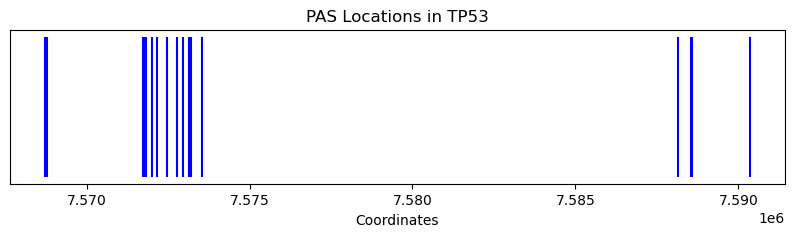

,PAS_ID,Chromosome,Position,Strand,Mean RPM,Intron/exon location,Ensemble ID,RefSeq Gene ID,Gene Symbol,Gene Name,FAMTOM ID,FANTOM Category,Extension,PAS type,PSE,PAS Signal,Conservation,intergenic_TE
122467,chr17:7568733:-,chr17,7568733,-,5.232099,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,YES,3'UTR(L),9.35%,AUUAAA,No,NO
122468,chr17:7568781:-,chr17,7568781,-,1.362268,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,YES,3'UTR(M),14.02%,AAUAAA,No,NO
122469,chr17:7571739:-,chr17,7571739,-,258.967422,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,3'UTR(M),100.0%,AAUAAA,Yes,NO
122470,chr17:7571785:-,chr17,7571785,-,1.727457,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,3'UTR(M),2.8%,NoPAS,Yes,NO
122471,chr17:7571827:-,chr17,7571827,-,1.011437,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,3'UTR(M),1.87%,NoPAS,Yes,NO
122472,chr17:7571998:-,chr17,7571998,-,1.646112,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,3'UTR(M),1.87%,NoPAS,No,NO
122473,chr17:7572161:-,chr17,7572161,-,2.087714,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,3'UTR(M),1.87%,NoPAS,No,NO
122474,chr17:7572469:-,chr17,7572469,-,1.042298,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,3'UTR(M),11.21%,NoPAS,No,NO
122475,chr17:7572772:-,chr17,7572772,-,1.278743,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,3'UTR(F),2.8%,NoPAS,No,NO
122476,chr17:7572945:-,chr17,7572945,-,1.066220,3' most exon,ENSG00000141510,7157,TP53,tumor protein p53,na,na,NO,CDS,33.64%,OtherPAS,No,NO


In [54]:
gene_of_interest = 'TP53'
gene_df = df[df['Gene Symbol'] == 'TP53']

plt.figure(figsize=(10,2))
plt.vlines(gene_df['Position'], ymin = 0, ymax = 1, color = 'blue')
plt.xlabel('Coordinates')
plt.yticks([])
plt.title(f'PAS Locations in {gene_of_interest}')
#plt.xlim(7661779, 7687550)
plt.show()

gene_df

# Building the architecture

In [ ]:
#Defining the architecture. 

class PolyAFinder(nn.Module):
    def __init__(self, seqlen = 201):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=8, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=6, padding='same'),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1))
        self.fc = nn.Linear(64,1)

    def forward(self, x):
        x = self.conv(x).squeeze(-1)
        return torch.sigmoid(self.fc(x))
        